In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas import Series, DataFrame, read_csv
from scipy.integrate import solve_ivp
from labellines import labelLine, labelLines

In [2]:
%matplotlib notebook

In [3]:
g = 9.8 # m / s2
R = 8.314 # J / mol K

In [4]:
substance_data = read_csv("res/substance_data.csv").set_index("Species")

def _as_substance_series(a, **kwargs):
    return Series(a, index=substance_data.index, **kwargs)

In [5]:
reaction_data = read_csv("res/reaction_data_galan.csv").set_index("j")

def _convert(df, src, dst, factor):
    _df = df
    if src in df.columns:
        _df[dst] = _df[src] * factor
    return _df


reaction_data = _convert(reaction_data, "Ea(cal/mol)", "Ea(J/mol)", 4.184)
reaction_data = _convert(reaction_data, "Eainv(cal/mol)", "Eainv(J/mol)", 4.184)

_Hf = substance_data["Hf(J/mol)"]

def _hstd(r, p):
    return np.sum([v * H for v, H in p]) - np.sum([v * H for v, H in r])

reaction_data.loc[1, "Hstd(J/mol)"] = _hstd(
    [(1, _Hf["GLY"]), (1, _Hf["AAC"])],
    [(1, _Hf["MAC"]), (1, _Hf["WAT"])]
)

reaction_data.loc[2, "Hstd(J/mol)"] = _hstd(
    [(1, _Hf["MAC"]), (1, _Hf["AAC"])],
    [(1, _Hf["DAC"]), (1, _Hf["WAT"])]
)

reaction_data.loc[3, "Hstd(J/mol)"] = _hstd(
    [(1, _Hf["DAC"]), (1, _Hf["AAC"])],
    [(1, _Hf["TAC"]), (1, _Hf["WAT"])]
)

def _as_reaction_series(a, **kwargs):
    return Series(a, index=reaction_data.index, **kwargs)

reaction_data

,A(L/mols),Ea(cal/mol),Ainv(L/mols),Eainv(cal/mol),Ea(J/mol),Eainv(J/mol),Hstd(J/mol)
j,,,,,,,
1,0.000524,616.8,0.000856,-3864.4,2580.6912,-16168.6496,-36240.0
2,0.000097,-1462.3,216.000000,8701.1,-6118.2632,36405.4024,-19480.0
3,0.062600,4964.1,1.860000,5137.5,20769.7944,21495.3000,-12410.0


In [6]:
reaction_rate_table = _as_reaction_series(None, dtype="object")

def _arrhenius(A, Ea, T):
    return A * np.exp(-Ea / (R * T))


def _create_reaction_rate_function(j, l):
    def _f(C, T):
        s = _as_substance_series(C)
        
        A = reaction_data.loc[j, "A(L/mols)"]
        Ea = reaction_data.loc[j, "Ea(J/mol)"]
        k = _arrhenius(A, Ea, T)
        
        Ainv = reaction_data.loc[j, "Ainv(L/mols)"]
        Eainv = reaction_data.loc[j, "Eainv(J/mol)"]
        kinv = _arrhenius(Ainv, Eainv, T)
        
        a, b, c, d = (s[l[i]] for i in range(0, 4))
        
        return -k * a * b + kinv * c * d
    return _f
    

reaction_rate_table[1] = _create_reaction_rate_function(1, ["GLY", "AAC", "MAC", "WAT"])
reaction_rate_table[2] = _create_reaction_rate_function(2, ["MAC", "AAC", "DAC", "WAT"])
reaction_rate_table[3] = _create_reaction_rate_function(3, ["DAC", "AAC", "TAC", "WAT"])

reaction_rate_table

j
1    <function _create_reaction_rate_function.<loca...
2    <function _create_reaction_rate_function.<loca...
3    <function _create_reaction_rate_function.<loca...
dtype: object

In [7]:
net_reaction_rate_table = _as_substance_series(None, dtype="object")

def _create_net_reaction_rate_function(f):
    def _f(C, T, r=reaction_rate_table):
        return f(C, T, r)
    return _f

net_reaction_rate_table["GLY"] = _create_net_reaction_rate_function(
    lambda C, T, r: r[1](C, T) 
)

net_reaction_rate_table["AAC"] = _create_net_reaction_rate_function(
    lambda C, T, r: r[1](C, T) + r[2](C, T) + r[3](C, T)
)

net_reaction_rate_table["WAT"] = _create_net_reaction_rate_function(
    lambda C, T, r: -r[1](C, T) - r[2](C, T) - r[3](C, T)
)

net_reaction_rate_table["TAC"] = _create_net_reaction_rate_function(
    lambda C, T, r: -r[3](C, T)
)

net_reaction_rate_table["DAC"] = _create_net_reaction_rate_function(
    lambda C, T, r: -r[2](C, T) + r[3](C, T)
)

net_reaction_rate_table["MAC"] = _create_net_reaction_rate_function(
    lambda C, T, r: -r[1](C, T) + r[2](C, T)
)

net_reaction_rate_table

Species
GLY    <function _create_net_reaction_rate_function.<...
AAC    <function _create_net_reaction_rate_function.<...
WAT    <function _create_net_reaction_rate_function.<...
TAC    <function _create_net_reaction_rate_function.<...
DAC    <function _create_net_reaction_rate_function.<...
MAC    <function _create_net_reaction_rate_function.<...
dtype: object

In [8]:
def evaluate_reaction_rates(C, T):
    # C: (L/mol), T: (K), return: (mol/Ls)
     return _as_reaction_series([r(C, T) for r in reaction_rate_table])


def evaluate_net_reaction_rates(C, T):
    # C: (L/mol), T: (K), return: (mol/Ls)
    return _as_substance_series([r(C, T) for r in net_reaction_rate_table])


def evaluate_temperature_rate(v, F, T, Ta, D, U):
    # v: (L/s), F: (mol/s), T: (K), Ta: (K), D: (m),  U: (W/m2K), return: (K/dm)
    _U = U / 100 # W/dm2K
    _D = D * 10 # dm
    At = np.pi * _D * _D / 4 # dm2
    r = evaluate_reaction_rates(F / v, T)
    
    # this works because the acetic acid has v=-1 in all reactions
    _1 = _U * 4 / _D * (Ta - T)
    _2 = np.sum([-rij * -Hrxnij for rij, Hrxnij in zip(r, reaction_data["Hstd(J/mol)"])])
    _3 = np.sum([Fi * Cpi for Fi, Cpi in zip(F, substance_data["Cp(J/molK)"])])
    
    return (_1 + _2) / _3 * At


def _as_objective_function_series(parameters):
    index = substance_data.index.union(["T(K)"], sort=False)
    return Series(parameters, index=index)


def _unpack_objective_function_vector(vector):
    s = _as_objective_function_series(vector)
    return s.loc(axis=0)[substance_data.index], s["T(K)"]


def _create_objective_function(v0, F0, Ta, D, U):
    def objective_function(L, vector):
        F, T = _unpack_objective_function_vector(vector)
        _r = evaluate_net_reaction_rates(F / v0, T)
        _T = evaluate_temperature_rate(v0, F, T, Ta, D, U)
        return np.concatenate((_r, [_T]))
    return objective_function


def _estimate_density(F):
    return np.average(substance_data["p(kg/m3)"])


def _bernoulli_pressure_drop(F, L):
    p = _estimate_density(F)
    return p * g * L * 9.86923e-6


def _estimate_volumetric_flow(F):
    s = _as_substance_series(F) # mol / s
    w = substance_data["MW(g/mol)"] * s / 1000 # kg / mol
    return np.sum(w / substance_data["p(kg/m3)"]) * 1000 # L / s


def solve(**kwargs):
    F0 = kwargs.pop("F0") # mol/s
    T0 = kwargs.pop("T0") # K
    P0 = kwargs.pop("P0") # atm
    Ta = kwargs.pop("Ta") # K
    D = kwargs.pop("D") # m
    U = kwargs.pop("U") # W /m2K
    L = kwargs.pop("L")
    v0 = _estimate_volumetric_flow(F0) # L / s
    
    # create the objective function
    _f = _create_objective_function(v0, F0, Ta, D, U)
    
    _L = L * 10 # dm
    
    # solve with RK45
    r = solve_ivp(_f, [0, _L], np.concatenate((F0, [T0])), **kwargs)
    
    index = r.t / 10
    
    # create the molar flows dataframe
    F = DataFrame(r.y[:-1].transpose(), index=index, columns=substance_data.index.to_numpy())
    
    # create a temperature series
    T = Series(r.y[-1], index=index, name="T(K)")
    
    pressure_drop = np.vectorize(lambda L: _bernoulli_pressure_drop(F0, L))
    
    # create a pressure series
    P = Series(P0 - pressure_drop(index), index=index, name="L(m)")
    
    # create a reaction rate series
    r = [evaluate_net_reaction_rates(f, t).to_numpy() for f, t in zip(F.to_numpy(), T.to_numpy())]
    r =  DataFrame(r, index=index, columns=substance_data.index.to_numpy())
    
    return F, T, P, r

In [9]:
F400, T400, P400, r400 = solve(
    F0 = [0.1, 1.6, 0, 0, 0, 0], # mol / s
    T0 = 400, # K
    P0 = 10, # atm
    Ta = 298.15, # K
    D = 1 * 2.54 / 100, # m
    U = 5, # W / m2 C
    L = 20, # m
    max_step=1
)

F420, T420, P420, r420 = solve(
    F0 = [0.1, 1.6, 0, 0, 0, 0], # mol / s
    T0 = 420, # K
    P0 = 10, # atm
    Ta = 298.15, # K
    D = 1 * 2.54 / 100, # m
    U = 5, # W / m2 C
    L = 20, # m
    max_step=1
)

F380, T380, P380, r380 = solve(
    F0 = [0.1, 1.6, 0, 0, 0, 0], # mol / s
    T0 = 380, # K
    P0 = 10, # atm
    Ta = 298.15, # K
    D = 1 * 2.54 / 100, # m
    U = 5, # W / m2 C
    L = 20, # m
    max_step=1
)

In [10]:
T380

0.000000     380.000000
0.008682     380.001158
0.095497     380.012526
0.195497     380.023708
0.295497     380.031465
                ...    
19.695497    378.034513
19.795497    378.023043
19.895497    378.011573
19.995497    378.000104
20.000000    377.999588
Name: T(K), Length: 203, dtype: float64

In [11]:
T400

0.000000     400.000000
0.008611     400.000991
0.094720     400.010687
0.194720     400.020250
0.294720     400.026714
                ...    
19.694720    397.449797
19.794720    397.435480
19.894720    397.421165
19.994720    397.406850
20.000000    397.406095
Name: T(K), Length: 203, dtype: float64

In [12]:
T420

0.000000     420.000000
0.008548     420.000821
0.094023     420.008817
0.194023     420.016623
0.294023     420.021596
                ...    
19.694023    416.869760
19.794023    416.852630
19.894023    416.835503
19.994023    416.818378
20.000000    416.817354
Name: T(K), Length: 203, dtype: float64

<IPython.core.display.Javascript object>


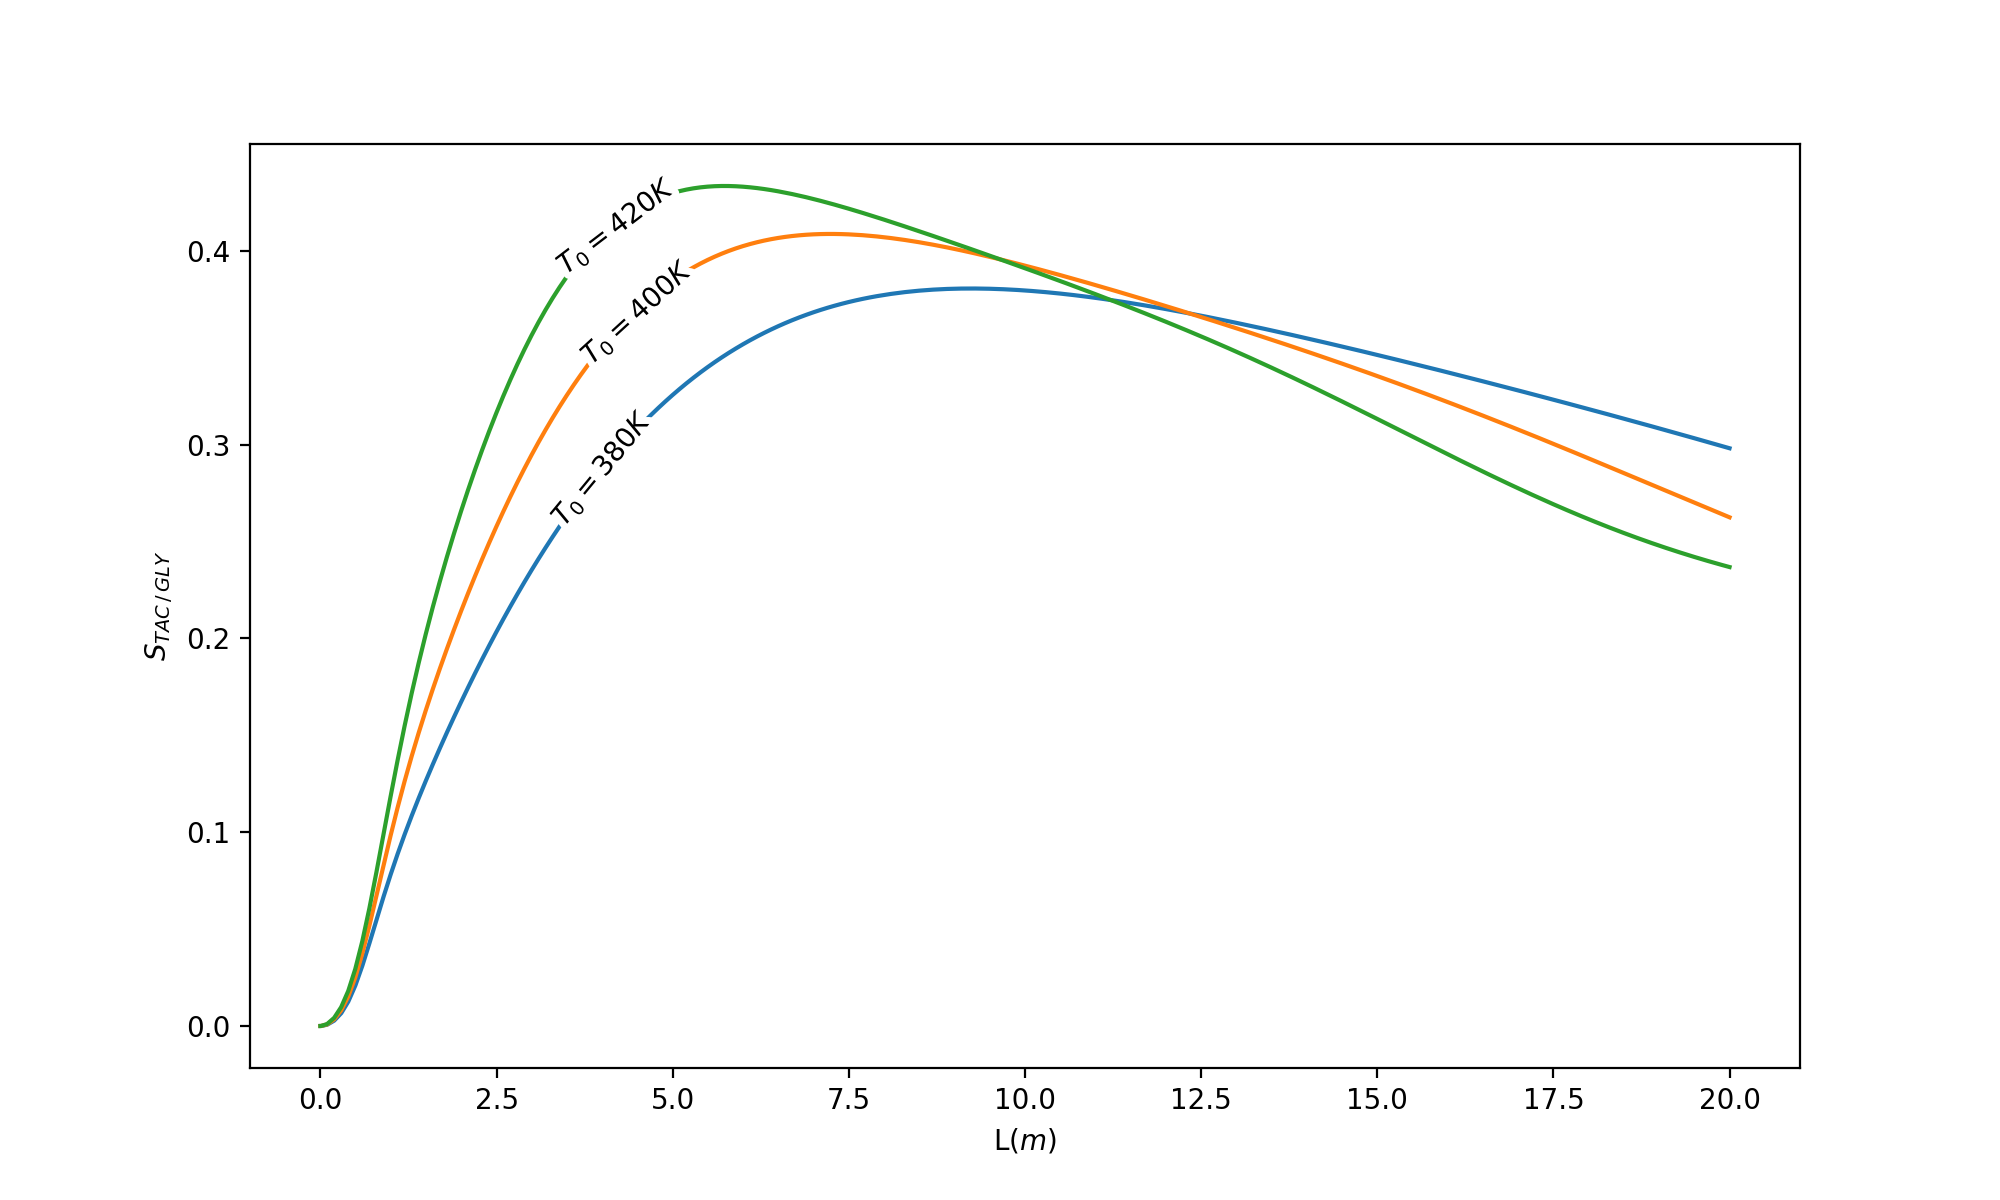

[Text(4.0, 0.2875740950599162, '$T_0=380K$'),
 Text(4.5, 0.36803507370358496, '$T_0=400K$'),
 Text(4.2, 0.4124804165269245, '$T_0=420K$')]

In [13]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

s_tac_wat_380 = r380["TAC"] / r380["WAT"]
s_tac_wat_400 = r400["TAC"] / r400["WAT"]
s_tac_wat_420 = r420["TAC"] / r420["WAT"]

ax.set_ylabel("$S_{TAC\,/\,GLY}$")
ax.set_xlabel("L$(m)$")
s_tac_wat_380.plot(ax=ax, legend=False, label="$T_0=380K$")
s_tac_wat_400.plot(ax=ax, legend=False, label="$T_0=400K$")
s_tac_wat_420.plot(ax=ax, legend=False, label="$T_0=420K$")
labelLines(ax.get_lines(), xvals=[4, 4.5, 4.2], yoffsets=[0, -0.002, -0.002], color="k")

<IPython.core.display.Javascript object>


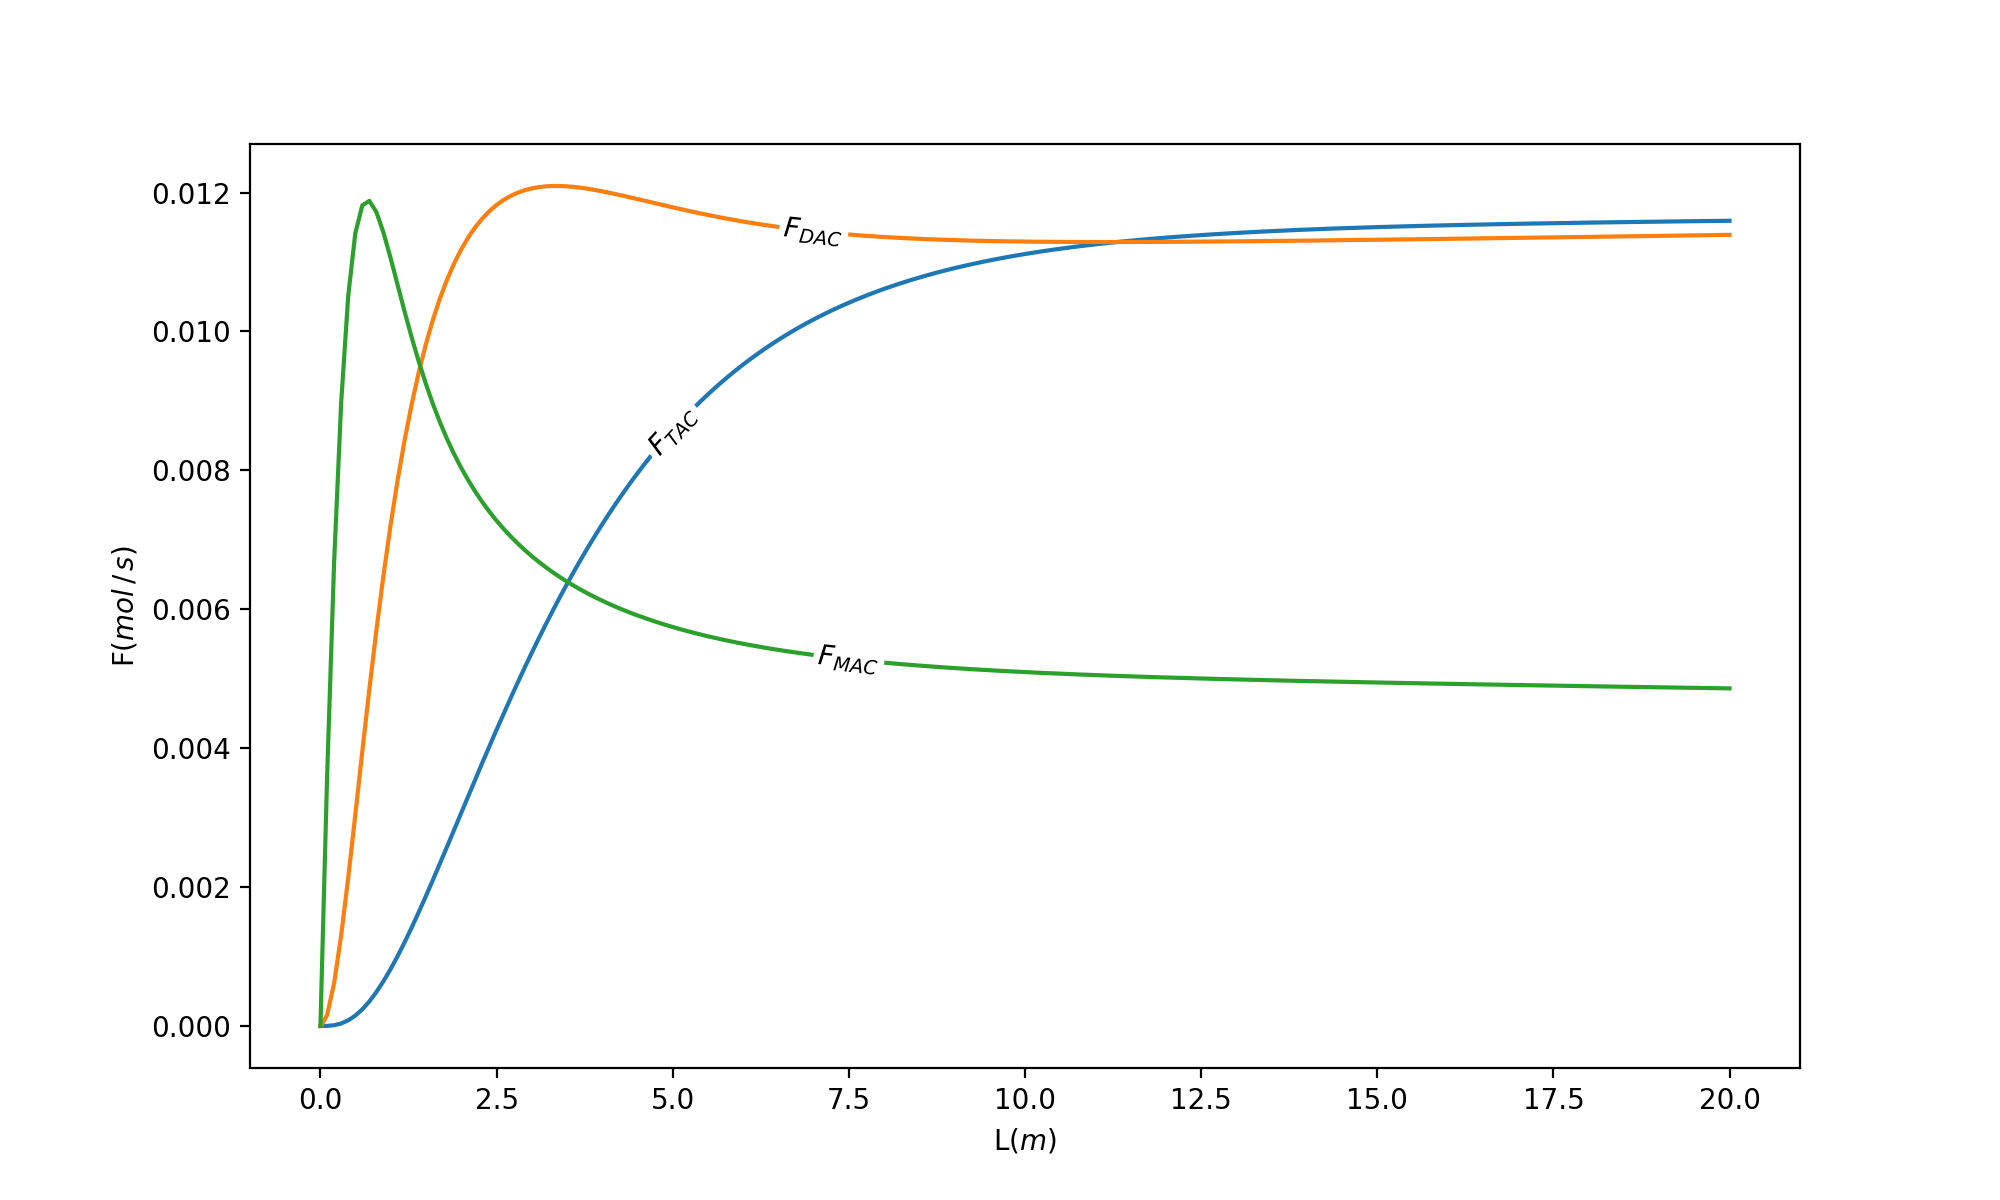

[Text(5.0, 0.008577900178902944, '$F_{TAC}$'),
 Text(7.0, 0.011443170023481235, '$F_{DAC}$'),
 Text(7.5, 0.00528203256678473, '$F_{MAC}$')]

In [14]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

F_of_interest_380 = F380[["TAC", "DAC", "MAC"]]
F_of_interest_400 = F400[["TAC", "DAC", "MAC"]]
F_of_interest_420 = F420[["TAC", "DAC", "MAC"]]


ax.set_ylabel("F$(mol\,/\,s)$")
ax.set_xlabel("L$(m)$")

for column in F_of_interest_420.columns:
    F_of_interest_420[column].plot(ax=ax, legend=False, label=f"$F_{{{column}}}$", style="-")     

labelLines(ax.get_lines(), xvals=[5, 7, 7.5], color="k")

In [15]:
y_tac_gly_380 = F380.iloc[-1]["TAC"] / (F380.iloc[0]["GLY"] - F380.iloc[-1]["GLY"])
y_tac_gly_400 = F400.iloc[-1]["TAC"] / (F400.iloc[0]["GLY"] - F400.iloc[-1]["GLY"])
y_tac_gly_420 = F420.iloc[-1]["TAC"] / (F420.iloc[0]["GLY"] - F420.iloc[-1]["GLY"])

y = DataFrame(
    [[y_tac_gly_380, y_tac_gly_400, y_tac_gly_420]], 
    index=["Y TAC/GLY"], 
    columns=["To = 380", "To = 400", "To = 420"]
)

y

,To = 380,To = 400,To = 420
Y TAC/GLY,0.429092,0.429399,0.416355


In [16]:
yearly_production = 10000 * 1000 # kg / y
production = yearly_production * (1 / 365)  * (1 / 24) * (1 / 3600)
production = production * 1000 / substance_data["MW(g/mol)"]["TAC"]
production

1.4532183881115135

In [17]:
production_g = F420.iloc[-1]["TAC"] * substance_data["MW(g/mol)"]["TAC"]
production_g

2.529809783667652

In [18]:
n_tubes = production / F420.iloc[-1]["TAC"]
n_tubes

125.34457012729456

In [19]:
substance_data

,Cp(J/molK),Hf(J/mol),MW(g/mol),p(kg/m3)
Species,,,,
GLY,221.18,-669600.0,92.0938,1260.00
AAC,159.80,-483520.0,60.0520,1050.00
WAT,75.38,-285830.0,18.0153,997.77
TAC,389.00,-1330800.0,218.2039,1160.00
DAC,340.98,-1120700.0,176.1672,1170.00
MAC,291.36,-903530.0,134.1305,1200.00
